In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# In this project, the objective was to perform sentiment analysis on the movie reviews to understand the sentiments of the audience after watching the movie.

> **Imported Sklearn APIs and other libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,LabelBinarizer,MinMaxScaler,LabelEncoder,MultiLabelBinarizer,QuantileTransformer,RobustScaler,StandardScaler,KBinsDiscretizer
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,validation_curve 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier,SGDOneClassSVM,RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import accuracy_score,classification_report,f1_score,confusion_matrix,log_loss
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,StackingClassifier, AdaBoostClassifier,BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_selection import SelectPercentile,chi2,RFECV,SelectKBest,mutual_info_classif
from sklearn.svm import SVC,LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator,TransformerMixin
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, hstack
from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
from imblearn.under_sampling import RandomUnderSampler,EditedNearestNeighbours
from imblearn.combine import SMOTEENN
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score,auc,f1_score
# from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.neural_network import MLPClassifier
import re
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (4, 4)

> **Loading the Datasets**

In [3]:
test_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
train_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
sample_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv")
movies_data = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
# from sklearn.dummy import DummyClassifier
# X = train_data["reviewText"]
# y = train_data["sentiment"]
# dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf.fit(X, y)
# DummyClassifier(strategy='most_frequent')
# dummy_clf.predict(X)

# sub = pd.DataFrame(dummy_clf.predict(test_data["reviewText"]), columns=['sentiment'])
# sub.index.name = 'id'
# sub.to_csv("testOutput.csv", encoding='utf-8')

# output = pd.read_csv("testOutput.csv")
# dummy_clf.score(X, y)

In [4]:
print(movies_data.shape)
movies_data.info()
# many columns of movie data are null so even after imputation of these column 
# our data may drift wrongly
# So will include only those columns in further analysis that 
# does not have much null values and imputation doesnot affect it adversely.

(143258, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage:

In [5]:
print(train_data.info())
train_data.isna().sum()
# In this dataset only reviewText has null values for which we will drop those rows 
# as null values will not help our model to know the sentiment of the unseen data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None


movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [6]:
train_data.shape

(162758, 5)

In [7]:
test_data.info()
# In this dataset only reviewText has null values for which we will fill them with empty strings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


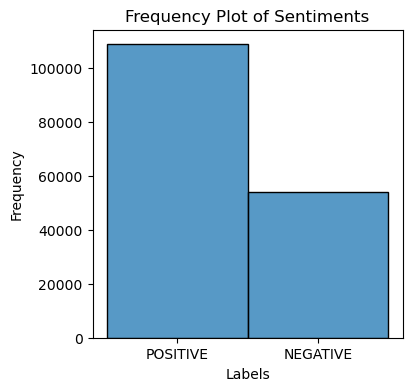

In [8]:
# distribution of sentiments of training data provided and 
# it is observed that the data is class marginally imbalanced
sns.histplot(train_data["sentiment"])
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Sentiments')
plt.show()

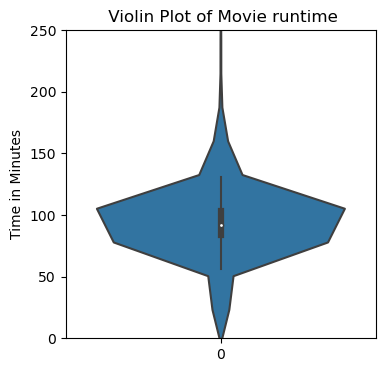

In [9]:
# this column represents the distribution of people watching movie and then reviewing
# after watching for how long they give negative or positive review 
# which will affect the accuracy of the model to predict the sentiment of 
# the test data review.
sns.violinplot(movies_data["runtimeMinutes"])
plt.ylim(0, 250)
plt.ylabel('Time in Minutes')
plt.title(' Violin Plot of Movie runtime')
plt.show()
# most common runtime of movie is around 80-120 mins

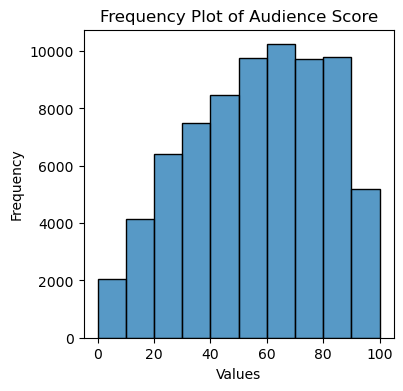

In [10]:
# the audience score is slightly left skewed means 
# audience will give high score to those movies whose review is on positive side since there are more
# Positive Sentiment as we observed earlier 
# it means the audience score will improve the accuracy of model in predicting the sentiment
sns.histplot(x=movies_data["audienceScore"],binwidth=10)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Audience Score')
plt.show()

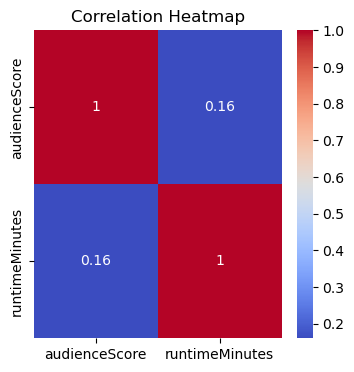

In [11]:
# checking the correlation between numerical columns
correlation_matrix = movies_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
#from this we get that they are not correlated with each other

In [12]:
# Review of how many movies we have in training dataset
train_data['movieid'].nunique()

16812

> **PreProcessing with Review Text in training and test data**
> * Dropped rows in train_data with no reviews
> * Filled with empty string in test_data
> * Cleaning of review of train and test data(consisting of links, brackets, special characters and punctuations)

In [13]:
# train_data["reviewText"].fillna(value='',inplace = True)
train_data.dropna(subset =["reviewText"],inplace = True,axis =0)
test_data["reviewText"].fillna(value='',inplace = True)
# Lower casing all column values for further imputation
train_data = train_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_data = test_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

train_data["reviewText"] = train_data["reviewText"].apply(lambda x: re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n|\.|\’|\d+|\w*\d\w*|[!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", '', x))
test_data["reviewText"] = test_data["reviewText"].apply(lambda x: re.sub(r"(http[s]?\://\S+)|([\[\(].*[\)\]])|([#@]\S+)|\n|\.|\’|\d+|\w*\d\w*|[!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]", '', x))
train_data["reviewText"] = train_data["reviewText"].apply(lambda x: re.sub(r"-", ' ', x))
test_data["reviewText"] = test_data["reviewText"].apply(lambda x: re.sub(r"-", ' ', x))

> Expanded Contracted words in reviewText so that when stop words are removed these words also get excluded which are not significant in sentiment prediction and the keyword "not" is which we can get by this method

In [14]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "can not","can't've": "can not have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contract_regex=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contract_regex.sub(replace, text)

# Expanding Contractions in the reviews
train_data["reviewText"]=train_data["reviewText"].apply(lambda x:expand(x))
test_data["reviewText"]=test_data["reviewText"].apply(lambda x:expand(x))

In [15]:
# removing repeated alphabet series like "zzz" that are mistyped by the reviewer
def replace_letters(match):
    return match.group(1) + match.group(1)
train_data["reviewText"] = train_data["reviewText"].apply(lambda x: re.sub(r'(\w)\1{2,}', replace_letters, x))
test_data["reviewText"] = test_data["reviewText"].apply(lambda x: re.sub(r'(\w)\1{2,}', replace_letters, x))

In [16]:
for index,text in enumerate(train_data["reviewText"][:5]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 henry selicks first movie since s coraline his fifth stop motion masterpiece
Review 2:
 with a cast that reads like the vogue oscar party guest list, valentine is day should have been can not miss cinema instead of standard hollywood schmaltz
Review 3:
 creed ii does not give us anything but another, slightly superior rocky sequel it wins on points just do not expect a knockout
Review 4:
 i know what you are thinking, but this is no limitless  as the cells multiply and lucy taps into more and more of her brain, it is new thrills new skills with each passing hour
Review 5:
 director fernando meirelles tells the story with urgency, and his sharp visual compositions and washed out cinematography ooze gangster life


> **Now exploring genre column of movies data**

In [17]:
print(movies_data["genre"].nunique())
movies_data["genre"].value_counts()

2912


Drama                                          27860
Documentary                                    15162
Comedy                                         11514
Mystery & thriller                              7015
Comedy, Drama                                   5479
                                               ...  
Fantasy, Drama, Musical                            1
Holiday, Drama, Musical                            1
Drama, War, Adventure, Action                      1
Action, Adventure, Comedy, Drama, Animation        1
Western, Comedy, Animation                         1
Name: genre, Length: 2912, dtype: int64

> **Further did preprocessing with this column in the following few cells 
> such that if any specific genre is present it should be encoded and not the combination of different 
genre encoded as one
> this reduced the dimension from two thousands to thirties**

In [18]:
#imputing genre column with most frequent genre
movies_data["genre"].fillna(value='Drama',inplace = True)
# cleaning genre column using regex
movies_data["genre"]= movies_data["genre"].apply(lambda x: re.sub(r"([\[\(].*[\)\]])|([#@]\S+)|\n|\.|\’|\d+|\s*(\w*\d\w*)\s*|[!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~]"
, '', x))
# converting into list for encoding
movies_data["genre"] = movies_data["genre"].str.split(', ')
movies_data["genre"][0]

['Comedy', 'Horror', 'Sci-fi']

In [19]:
# removed duplicate rows of same movie from movies data set and columns which are mostly NaN 
# and the date of release of movie will not affect reviewer sentiment about the movie
# and the title is already covered in movie id
movies_data = movies_data.drop_duplicates(subset=['movieid'], keep='first')
movies_data.dropna(axis=1, thresh=(len(movies_data)*.5), inplace=True)
movies_data.drop(["releaseDateStreaming","title"],inplace = True,axis = 1)
print(movies_data.shape)
movies_data.head()

(126404, 6)


,movieid,audienceScore,runtimeMinutes,genre,originalLanguage,director
0,han_solo_heroic_myth_wonder_woman,50.0,75.0,"[Comedy, Horror, Sci-fi]",English,Claude Nicolet
1,voyage_tyler_durden_han_solo_stardust,NaN,114.0,[Drama],English,Nathan Haack
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,120.0,[Drama],Korean,Theresa Smith
3,elegant_hermione_granger,60.0,90.0,"[Action, Mystery & thriller]",English,Donald Lewis
4,adventure_rocky_balboa,70.0,80.0,"[Fantasy, Adventure, Animation]",English,Howard Simms


> **Merging movies and train data**

In [20]:
train_data.shape

(156311, 5)

In [21]:
# movies_data.join(train_data,how='right',on=train_data['movieid'])
train = movies_data.merge(train_data,how = 'right',left_on="movieid",right_on='movieid')
train.head()

,movieid,audienceScore,runtimeMinutes,genre,originalLanguage,director,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,65.0,105.0,"[Comedy, Animation, Adventure, Fantasy]",English,Bennie Basso,benjamin henry,False,henry selicks first movie since s coraline his...,positive
1,tony_montana_frodo_baggins_v_rocky_balboa,NaN,91.0,[Action],English,Alma White,felicia lopez,False,with a cast that reads like the vogue oscar pa...,negative
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,80.0,130.0,[Drama],English,Bobby Oleary,mr. charles burgess,True,creed ii does not give us anything but another...,positive
3,lara_croft_glimmer,NaN,15.0,[Drama],Spanish,Eric Hutcherson,ryan barrett,False,"i know what you are thinking, but this is no l...",positive
4,jason_bourne_surreal_the_terminator_indiana_jones,97.0,131.0,"[Crime, Drama]",Portuguese (Brazil),John Trent,alexander glover,False,director fernando meirelles tells the story wi...,positive


In [22]:
train.describe()
# we get the statistical summary of numerical columns and 
# found that they both are of different scales

,audienceScore,runtimeMinutes
count,143554.000000,153059.000000
mean,65.239436,106.988736
std,19.915823,22.101083
min,0.000000,4.000000
25%,51.000000,93.000000
50%,68.000000,104.000000
75%,82.000000,118.000000
max,100.000000,561.000000


In [23]:
# Splitting features and label
X_=train.drop(["sentiment"] , axis=1)
y= train["sentiment"]

> **Encoding the label for using it in model**

In [25]:
lb=LabelEncoder()
y_train=lb.fit_transform(y)
y_train

array([1, 0, 1, ..., 1, 0, 1])

In [27]:
X_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156311 entries, 0 to 156310
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             156311 non-null  object 
 1   audienceScore       143554 non-null  float64
 2   runtimeMinutes      153059 non-null  float64
 3   genre               156311 non-null  object 
 4   originalLanguage    153168 non-null  object 
 5   director            156311 non-null  object 
 6   reviewerName        156311 non-null  object 
 7   isFrequentReviewer  156311 non-null  bool   
 8   reviewText          156311 non-null  object 
dtypes: bool(1), float64(2), object(6)
memory usage: 10.9+ MB


> **Preprocessing using Column Transformer and Pipelines on numerical and categorical features.**
> * applied KNNImputer to impute null values and then MinMaxScaler so to make the numerical values in a range
> * applied Simple Imputer and OneHotEncoder on categorical data
> * applied TfidfVectorizer on review text column

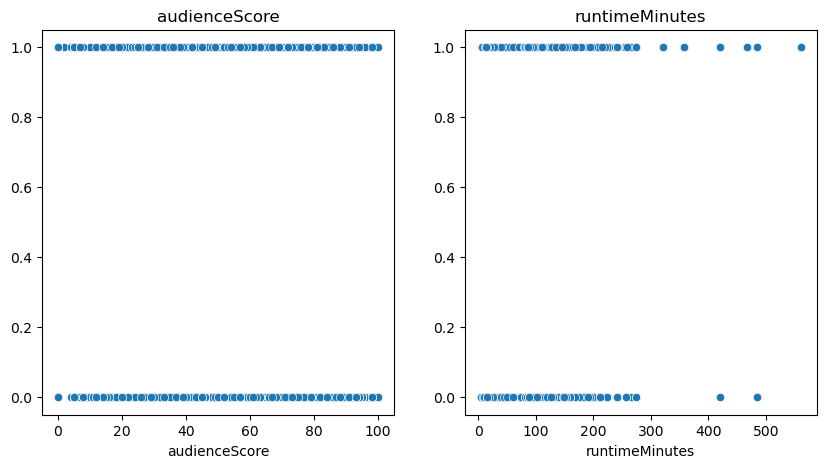

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=X_['audienceScore'],y=y_train, ax=axes[0])
axes[0].set_title('audienceScore')

sns.scatterplot(x=X_['runtimeMinutes'],y=y_train, ax=axes[1])
axes[1].set_title('runtimeMinutes')
plt.show()

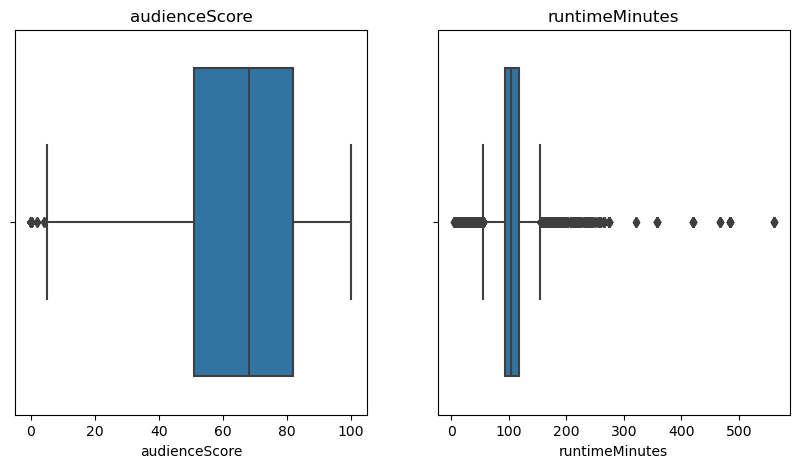

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(x=X_['audienceScore'], ax=axes[0])
axes[0].set_title('audienceScore')

sns.boxplot(x=X_['runtimeMinutes'], ax=axes[1])
axes[1].set_title('runtimeMinutes')
plt.show()

In [30]:

numeric_features = ["audienceScore","runtimeMinutes"]

numeric_transformer = Pipeline(
    steps=[
        ("knnimp", KNNImputer(weights='distance')),
           ("robust",RobustScaler()),
           ("minmax", MinMaxScaler())
          ])



categorical_transformer = Pipeline(
    steps=[('simp',SimpleImputer(strategy='most_frequent')),
        ("encode", OneHotEncoder(handle_unknown='ignore')),
    ]
)

review_vectorizer = Pipeline([('tfidf',TfidfVectorizer(ngram_range=(1, 3)))])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, ["originalLanguage"]),
        ("encode",OneHotEncoder(handle_unknown="ignore"),["isFrequentReviewer","reviewerName","director"]),
        ("tfidf",review_vectorizer,"reviewText")
    ]
)
X_train = preprocessor.fit_transform(X_,y_train)
print(X_train.shape)
X_train

(156311, 3197244)


<156311x3197244 sparse matrix of type '<class 'numpy.float64'>'
	with 10186659 stored elements in Compressed Sparse Row format>

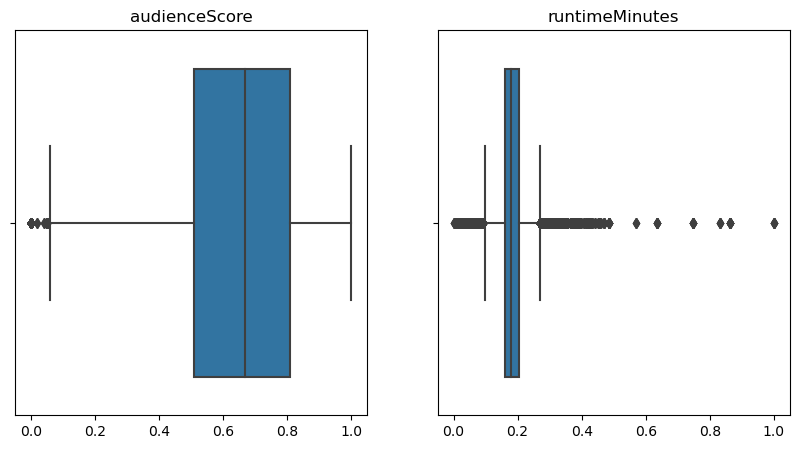

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x=X_train[:,0].toarray(), ax=axes[0])
axes[0].set_title('audienceScore')

sns.boxplot(x=X_train[:,1].toarray(), ax=axes[1])
axes[1].set_title('runtimeMinutes')
plt.show()

In [32]:
mlb = MultiLabelBinarizer(sparse_output=True)
genre_encoded = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(X_.pop("genre")),
                )
X_train = hstack([X_train, genre_encoded])
print(X_train.shape)

(156311, 3197278)


In [33]:
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Anime', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Faith & spirituality', 'Fantasy',
       'Foreign', 'Gay & lesbian', 'Health & wellness', 'History',
       'Holiday', 'Horror', 'Kids & family', 'Lgbtq+', 'Music', 'Musical',
       'Mystery & thriller', 'Nature', 'News', 'Other', 'Romance',
       'Sci-fi', 'Short', 'Sports', 'Sports & fitness', 'Stand-up',
       'Variety', 'War', 'Western'], dtype=object)

In [35]:
# applying same preprocessing to test data 
test_data.rename(columns={"isTopCritic": "isFrequentReviewer"},inplace=True)
test = movies_data.merge(test_data,how = 'right',left_on="movieid",right_on='movieid')
X_test=preprocessor.transform(test)
print(X_test.shape)
genre_encoded = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(test.pop("genre")),
                )
X_test = hstack([X_test, genre_encoded])
print(X_test.shape)

(55315, 3197244)
(55315, 3197278)


> **Feature selection using SelectKBEst**

In [36]:
num_features = int(np.ceil(0.85 * X_train.shape[1]))
fs = SelectKBest(score_func=chi2, k=num_features)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test = fs.transform(X_test)
# X_train = fs.transform(X_train)

> **Train test split for model evaluation**

In [37]:
X_train_fs.shape

(156311, 2493877)

In [38]:
X_tr,X_ts,y_tr,y_ts = train_test_split(X_train_fs,y_train,test_size = 0.3,random_state=36)
# X_tr,X_ts,y_tr,y_ts = train_test_split(X_train,y_train,test_size = 0.3,random_state=36)

X_tr.shape,X_ts.shape

((109417, 2493877), (46894, 2493877))

#### **Tried working on class imbalance**

In [39]:
# under sampling technique for class imbalance, but gave bad score
# under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_under, y_under = under_sampler.fit_resample(X_tr, y_tr)
# lsvc = LinearSVC(random_state =0,penalty = 'l2',loss = 'hinge')
# lsvc.fit(X_under, y_under)
# print(lsvc.score(X_ts,y_ts))                                     #0.7948693343569075
# print(lsvc.score(X_tr,y_tr))                                     #0.8359749856055275
# print(lsvc.score(X_train,y_train))                               #0.827753644977001

In [40]:
#over sampling taking lot of time as number of samples are huge in dataset and didnot give bett
# ada = ADASYN(random_state=42)
# X_resampled, y_resampled = ada.fit_resample(X_tr, y_tr)
# lsvc = LinearSVC(random_state =0,penalty = 'l2',loss = 'hinge')
# lsvc.fit(X_resampled, y_resampled)
# print(lsvc.score(X_resampled,y_resampled))                          #0.8649567275466684             
# print(lsvc.score(X_ts,y_ts))                                        #0.7974602565332821
# print(lsvc.score(X_tr,y_tr))                                        #0.8419886763482822
# y_pred = lsvc.predict(X_ts)
# print("Classification Report:")
# print(classification_report(y_ts, y_pred))


In [41]:
# applied SMOTE which is better than adasyn
# smote = SMOTE(random_state=42)
# X_resampled_smote, y_resampled_smote = smote.fit_resample(X_tr, y_tr)
# lsvc = LinearSVC(random_state =0,penalty = 'l2',loss = 'hinge')
# lsvc.fit(X_resampled_smote, y_resampled_smote)
# print(lsvc.score(X_resampled_smote,y_resampled_smote))                #0.867106188676546                       
# print(lsvc.score(X_ts,y_ts))                                          #0.8012986597575409
# print(lsvc.score(X_tr,y_tr))                                          #0.8432921758044911
# # print(lsvc.score(X_train,y_train))                                  
# y_pred = lsvc.predict(X_ts)
# print("Classification Report:")
# print(classification_report(y_ts, y_pred))
# cm = confusion_matrix(y_ts, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [42]:
# log_reg = LogisticRegression(random_state =0,solver = 'saga',penalty = 'l1',C=10)
# log_reg.fit(X_resampled_smote, y_resampled_smote)
# print(log_reg.score(X_ts,y_ts))
# print(log_reg.score(X_tr,y_tr))
# y_pred = log_reg.predict(X_ts)
# print("Classification Report:")
# print(classification_report(y_ts, y_pred))


####  **Without class imbalance**

> **Linear SVM and its hyperparameter tuning**

In [43]:

lsvc = LinearSVC(random_state =42,penalty = 'l2',loss = 'hinge')
lsvc.fit(X_tr, y_tr)
print(lsvc.score(X_ts,y_ts))
print(lsvc.score(X_tr,y_tr))
y_pred = lsvc.predict(X_ts)
print("Classification Report:")
print(classification_report(y_ts, y_pred))


0.8448628822450633
0.9782483526325891
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     15539
           1       0.86      0.91      0.89     31355

    accuracy                           0.84     46894
   macro avg       0.83      0.81      0.82     46894
weighted avg       0.84      0.84      0.84     46894



**Best Model Linear SVC**
> Gave highest test score

In [44]:
param_grid = {
    'C': [0.1,0.5, 1.0, 1.5,2,5,],
    'penalty': [ 'l2'],
    'loss': ['hinge', 'squared_hinge'],
}
svc = LinearSVC(max_iter=1000)
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')

print("Scores with Grid Search")
grid_search.fit(X_tr, y_tr)
# print(grid_search.score(X_train_fs,y_res))
print(grid_search.score(X_ts,y_ts))
print(grid_search.score(X_tr,y_tr))

Scores with Grid Search
0.8511749904038897
0.997404425272124


In [45]:
grid_search.best_params_

{'C': 2, 'loss': 'hinge', 'penalty': 'l2'}

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     15539
           1       0.87      0.92      0.89     31355

    accuracy                           0.85     46894
   macro avg       0.84      0.82      0.83     46894
weighted avg       0.85      0.85      0.85     46894



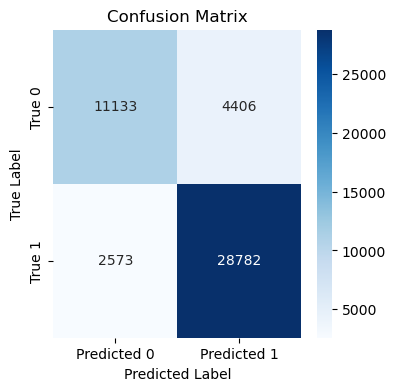

In [48]:
pen=grid_search.best_params_["penalty"]
C=grid_search.best_params_["C"]
loss=grid_search.best_params_["loss"]
svc1 = LinearSVC(random_state =42,penalty = pen,loss = loss,C=C)
svc1.fit(X_tr, y_tr)
# print(lsvc1.score(X_ts,y_ts))
# print(lsvc1.score(X_tr,y_tr))
y_pred = svc1.predict(X_ts)
print("Classification Report:")
print(classification_report(y_ts, y_pred))
cm = confusion_matrix(y_ts, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

0.8482321832217341
0.9990038111079631
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76     15539
           1       0.86      0.92      0.89     31355

    accuracy                           0.85     46894
   macro avg       0.84      0.81      0.82     46894
weighted avg       0.85      0.85      0.85     46894



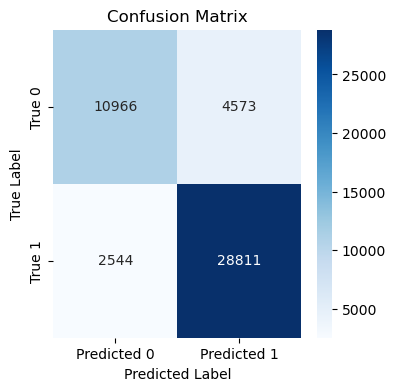

In [62]:
lsvc1 = LinearSVC(random_state =42,penalty = 'l2',loss = 'squared_hinge',C=1)
lsvc1.fit(X_tr, y_tr)
print(lsvc1.score(X_ts,y_ts))
print(lsvc1.score(X_tr,y_tr))
y_pred = lsvc1.predict(X_ts)
print("Classification Report:")
print(classification_report(y_ts, y_pred))
cm = confusion_matrix(y_ts, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

> **Naive Bayes Classifier and its hyperparameter tuning**

In [51]:
naive_bayes  = MultinomialNB(alpha = 0.1)


# Train the Naive Bayes classifier
naive_bayes.fit(X_tr, y_tr)
print(naive_bayes.score(X_tr,y_tr))
# Make predictions on the test set
predictions = naive_bayes.predict(X_ts)

# Evaluate the performance
print("Accuracy:", accuracy_score(y_ts, predictions))
print("Classification Report:")
print(classification_report(y_ts, predictions))

0.9906230293281666
Accuracy: 0.8427304132724869
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73     15539
           1       0.84      0.94      0.89     31355

    accuracy                           0.84     46894
   macro avg       0.84      0.79      0.81     46894
weighted avg       0.84      0.84      0.84     46894



0.9991591800177303
Best Alpha: 1e-05
Accuracy: 0.8841216360301958
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     15539
           1       0.92      0.91      0.91     31355

    accuracy                           0.88     46894
   macro avg       0.87      0.87      0.87     46894
weighted avg       0.88      0.88      0.88     46894



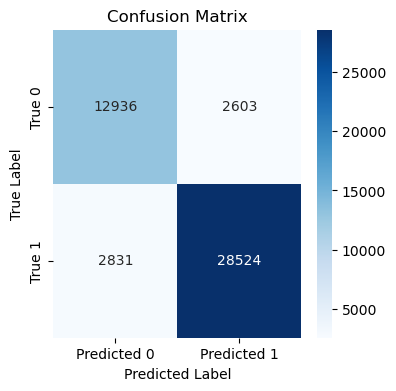

In [65]:
naive_bayes_classifier = MultinomialNB()

#  Define hyperparameters for Grid Search
param_grid = {
    'alpha': [1e-06,1e-05,1e-04,1e-03,1e-02, 0.1,1,2]  # Try different values of alpha
}

#  Perform Grid Search with cross-validation
grid_search = GridSearchCV(naive_bayes_classifier, param_grid, cv=5)
grid_search.fit(X_tr, y_tr)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

#Train the Naive Bayes classifier with the best hyperparameters
best_naive_bayes_classifier = MultinomialNB(alpha=best_alpha)
best_naive_bayes_classifier.fit(X_tr, y_tr)
print(best_naive_bayes_classifier.score(X_tr,y_tr))
# Make predictions on the test set
y_pred = best_naive_bayes_classifier.predict(X_ts)

# Evaluate the performance
print("Best Alpha:", best_alpha)
print("Accuracy:", accuracy_score(y_ts, y_pred))
print("Classification Report:")
print(classification_report(y_ts, y_pred))
cm = confusion_matrix(y_ts, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
sgd = sgd_classifier = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, learning_rate='optimal', eta0=0.01,
                              max_iter=1000, class_weight='balanced')
sgd.fit(X_tr, y_tr)
print(sgd.score(X_ts,y_ts))
print(sgd.score(X_tr,y_tr))
y_pred = sgd.predict(X_ts)
print("Classification Report:")
print(classification_report(y_ts, y_pred))

0.7358510683669552
0.7658224955902647
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.77      0.66     15539
           1       0.86      0.72      0.78     31355

    accuracy                           0.74     46894
   macro avg       0.72      0.75      0.72     46894
weighted avg       0.77      0.74      0.74     46894



In [55]:
# param_grid = {
#     'alpha': [0.0001, 0.001, 0.01],
#     'penalty': ['l2', 'l1', 'elasticnet'],
#     'l1_ratio': [0.1, 0.3, 0.5],
#     'eta0': [0.01, 0.1, 0.5],
#     'max_iter': [1000, 2000, 3000],
#     'learning_rate':['optimal','invscaling','adaptive']
# }
# sgd = SGDClassifier(loss='log_loss', random_state=42)
# random_search = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy')
# random_search.fit(X_tr, y_tr)
# # print(grid_search.score(X_train_fs,y_train))
# print(random_search.score(X_ts,y_ts))
# print(random_search.score(X_tr,y_tr))
# y_pred = random_search.predict(X_ts)
# print("Classification Report:")
# print(classification_report(y_ts, y_pred))

In [60]:
log_reg = LogisticRegression(random_state =0,solver = 'saga',penalty = 'l2',C=5)
log_reg.fit(X_tr, y_tr)
# print(log_reg.score(X_train,y_train))
print(log_reg.score(X_ts,y_ts))
print(log_reg.score(X_tr,y_tr))
y_pred = log_reg.predict(X_ts)
print("Classification Report:")
print(classification_report(y_ts, y_pred))

0.8383801765684309
0.9841066744655766
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.74     15539
           1       0.85      0.92      0.88     31355

    accuracy                           0.84     46894
   macro avg       0.83      0.80      0.81     46894
weighted avg       0.84      0.84      0.83     46894



In [58]:
# param_grid = {
#     "C": [ 0.1, 1, 10],  # Regularization strength
#     "solver": ["saga", "lbfgs"]
# }
# logreg = LogisticRegression(max_iter=1000, random_state=42,penalty='l2')
# grid_search = GridSearchCV(logreg, param_grid, cv=5,n_jobs=-1)
# grid_search.fit(X_tr, y_tr)

# # Get the best hyperparameters
# best_C = grid_search.best_params_["C"]
# best_solver = grid_search.best_params_["solver"]

# # Train the logistic regression model with the best hyperparameters
# logreg_best = LogisticRegression(C=best_C, solver=best_solver, max_iter=1000, random_state=42)
# logreg_best.fit(X_tr, y_tr)
# print(logreg_best.score(X_ts,y_ts))
# print(logreg_best.score(X_tr,y_tr))
# # Evaluate the model
# y_pred = logreg_best.predict(X_ts)
# # accuracy = accuracy_score(y_ts, y_pred)
# # print("Accuracy:", accuracy)
# print(classification_report(y_ts, y_pred))

0.8426024651341323
0.9975872122247914
              precision    recall  f1-score   support

           0       0.81      0.69      0.74     15539
           1       0.86      0.92      0.89     31355

    accuracy                           0.84     46894
   macro avg       0.83      0.80      0.82     46894
weighted avg       0.84      0.84      0.84     46894



In [59]:
grid_search.best_params_

{'C': 10, 'solver': 'lbfgs'}

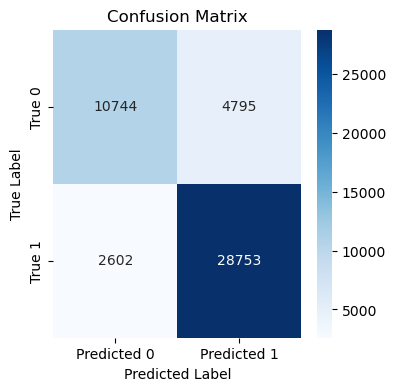

In [47]:
cm = confusion_matrix(y_ts, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# decision_tree = DecisionTreeClassifier(
#     max_depth=10,
#     min_samples_split=5,
#     min_samples_leaf=2,
# #     max_features=60000,  # Set to None to consider all features
#     random_state=42
# )

# # Train the decision tree classifier on the training data
# decision_tree.fit(X_tr, y_tr)

# # Make predictions on the test data
# y_pred = decision_tree.predict(X_ts)

# # Evaluate the model
# print(decision_tree.score(X_ts,y_ts))
# print(decision_tree.score(X_tr,y_tr))

# # 0.7046668585868279
# # 0.7030660226473034
# print(classification_report(y_ts, y_pred))

0.7019448117029897
0.7009605454362667
              precision    recall  f1-score   support

           0       0.60      0.31      0.41     15539
           1       0.72      0.89      0.80     31355

    accuracy                           0.70     46894
   macro avg       0.66      0.60      0.61     46894
weighted avg       0.68      0.70      0.67     46894



In [ ]:
# decision_tree_classifier = DecisionTreeClassifier()
# param_grid = {
    
#     'max_depth': [5, 10, 15,20],
#     'min_samples_split': [5, 10,15],
#     'min_samples_leaf': [2,4,8,12]
# }

# random_search = RandomizedSearchCV(decision_tree_classifier, param_grid, cv=5)
# random_search.fit(X_tr, y_tr)

# best_params = random_search.best_params_

# best_decision_tree_classifier = DecisionTreeClassifier(**best_params)
# best_decision_tree_classifier.fit(X_tr, y_tr)

# predictions = best_decision_tree_classifier.predict(X_ts)
# print(best_decision_tree_classifier.score(X_tr,y_tr))
# print("Best Hyperparameters:", best_params)
# print("Accuracy:", accuracy_score(y_ts, predictions))
# print("Classification Report:")
# print(classification_report(y_ts, predictions))

# 0.7656579873328642
# Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
# Accuracy: 0.7172696158398106

In [ ]:
# base_estimator = SVC(kernel='linear', random_state=42, C=1)  # Linear SVM as the base estimator
# # svm = LinearSVC(random_state =42,penalty = 'l2',loss = 'squared_hinge',C=1)
# # log_reg = LogisticRegression(random_state =42,solver = 'saga',penalty = 'l2',C=5)
# bagged_svm = BaggingClassifier(estimator=base_estimator, n_estimators=20, random_state=42)
# bagged_svm.fit(X_tr, y_tr)

# # # Make predictions on the test data
# y_pred = bagged_svm.predict(X_ts)

# # # Evaluate the model
# print(bagged_svm.score(X_ts,y_ts))
# print(bagged_svm.score(X_tr,y_tr))

# # 0.8420053738218108
# # 0.9904311030278659

# print("Classification Report:")
# print(classification_report(y_ts, y_pred))

# cm = confusion_matrix(y_ts, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
# base_estimator = SVC(kernel='linear', probability=True)  # Linear SVM as the base estimator
# adaboost_svm = AdaBoostClassifier(estimator=svm, n_estimators=50, random_state=42,algorithm='SAMME')

# # # Train the gradient boosting classifier on the training data
# adaboost_svm.fit(X_tr, y_tr)

# # # Make predictions on the test data
# y_pred = adaboost_svm.predict(X_ts)

# # # Evaluate the model
# print(adaboost_svm.score(X_tr,y_tr))
# print(adaboost_svm.score(X_ts,y_ts))

# # 0.7587603525935971
# # 0.720628218661037

# print("Classification Report:")
# print(classification_report(y_ts, y_pred))

In [63]:
scores = cross_val_score(lsvc1, X_train_fs, y_train, cv=5)
print(scores)
scores.mean()

[0.85202956 0.85333632 0.85765466 0.85256861 0.85164097]


0.8534460237377282

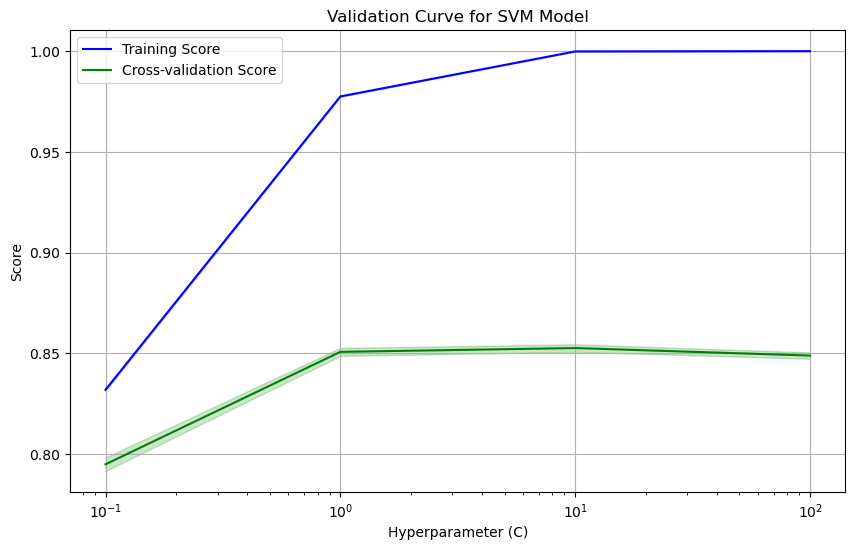

In [66]:
param_range = [0.1, 1, 10, 100]
# Calculate validation curve
train_scores, test_scores = validation_curve(
    lsvc, X_train_fs, y_train, param_name='C', param_range=param_range, cv=5, 
    scoring='accuracy')

# Calculate mean and standard deviation of the scores
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, mean_train_scores, label='Training Score', color='blue')
plt.fill_between(param_range, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2, color='blue')
plt.plot(param_range, mean_test_scores, label='Cross-validation Score', color='green')
plt.fill_between(param_range, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2, color='green')
plt.xscale('log')  # If the hyperparameter values are on a large scale, use log scale for better visualization
plt.xlabel('Hyperparameter (C)')
plt.ylabel('Score')
plt.title('Validation Curve for SVM Model')
plt.legend()
plt.grid()
plt.show()


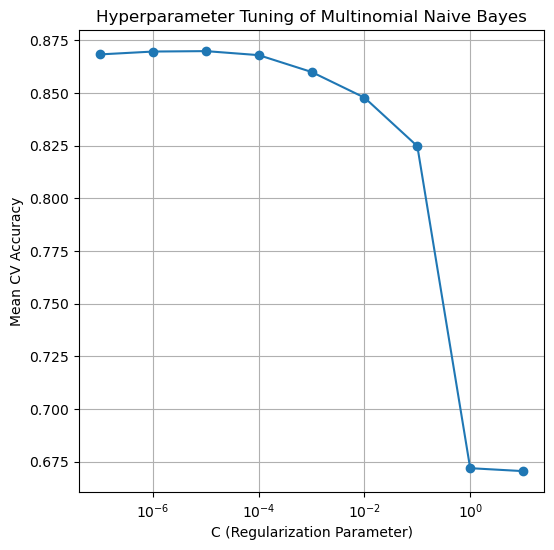

In [56]:
param_grid = {
    'alpha': np.logspace(-7, 1, 9),
}

# Create the LinearSVC model
nb_model = MultinomialNB()

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(nb_model, param_grid, cv=5)
grid_search.fit(X_tr, y_tr)

# Extract the results of hyperparameter tuning
param_values = grid_search.cv_results_['param_alpha'].data
mean_scores = grid_search.cv_results_['mean_test_score']

# Create a line plot for HPT
plt.figure(figsize=(6, 6))
plt.plot(param_values, mean_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Mean CV Accuracy')
plt.title('Hyperparameter Tuning of Multinomial Naive Bayes')
plt.grid(True)
plt.show()

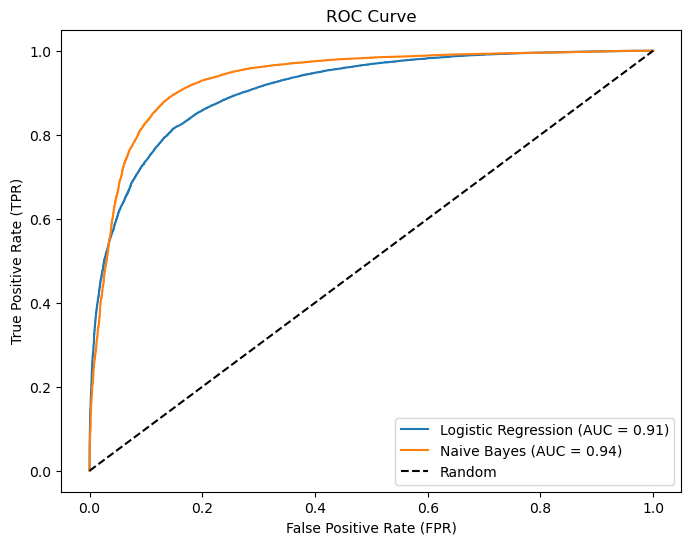

In [58]:
# comparison of naive bayes and logistics regression

y_pred_prob_logreg = log_reg.predict_proba(X_ts)[:, 1]
y_pred_prob_nb = best_naive_bayes_classifier.predict_proba(X_ts)[:, 1]

# Calculate ROC curve and AUC for each model
fpr_logreg, tpr_logreg, _ = roc_curve(y_ts, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_nb, tpr_nb, _ = roc_curve(y_ts, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logreg)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
sub = pd.DataFrame(lsvc1.predict(X_test), columns=['sentiment'])
sub.index.name = 'id'
sub=sub.replace(0,"NEGATIVE")
sub=sub.replace(1,"POSITIVE")
sub.to_csv("submission.csv", encoding='utf-8')

output = pd.read_csv("submission.csv")

**Comparison of best three models**

Linear SVM
> Effective in high-dimensional spaces, making it suitable for text data with a large number of features 

> Memory-efficient compared to some other classifiers.

Logistics Regression
> Interpretable and easy to understand the impact of features on the predicted probability.

Naive Bayes
> robust to irrelevant features due to its independence assumption,computationally efficient and can handle large datasets.
